# The Analyzer

In [34]:
# Libraries
import folium
import pandas as pd
import matplotlib.pyplot as plt
import mysql.connector as sql
import seaborn as sns
import scipy.stats as stats


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Import data

In [25]:
# Connect to Wine Database
db_connection = sql.connect(host='lx26.hoststar.hosting',
                            database="ch309974_DA_winery", user='ch309974_DA_winery_user', password='ch309974_DA_winery_user1!')

# We assume that all values that are 0 or null don't have Ratings. That's why we exclude it.
query = 'SELECT * FROM wine where bewertung > 0'
df_response = pd.read_sql(sql=query, con=db_connection)

# Remove some 'extreme' values
df = df_response.loc[(df_response['preis_chf'] >= 5) &
            (df_response['preis_chf'] <= 500)]

# Reset index
df = df.reset_index(drop=True)

## Compare wine type to price

In [26]:
# Read the data to a pandas data frame
df_price = df[['typ', 'preis_cl']]

# Show categories of 'Make'
print(df_price['typ'].value_counts())

# Drop extreme values
df_price = df_price.drop(df_price[df_price.preis_cl > 1].index)
df_price.head()

rot           775
weiss         245
rose           93
schaumwein     90
champagner     58
dessert        28
Name: typ, dtype: int64


,typ,preis_cl
0,rot,0.27
1,rot,0.17
2,rot,0.44
3,rot,0.44
4,rot,0.29


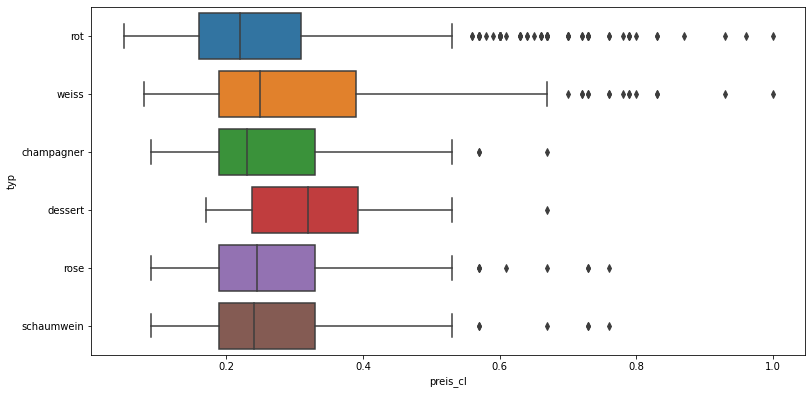

In [32]:
# Plot boxplot with groups
plt.figure(figsize=(12.8,6.4))
ax = sns.boxplot(x="preis_cl",
                 y="typ",
                 data=df_price,
                 orient='h')
plt.show()

## ANOVA

In [37]:
# Create subsets (groups)
red = df.loc[df['typ'] == 'rot']
white = df.loc[df['typ'] == 'weiss']
champagne = df.loc[df['typ'] == 'champagner']

# Create ANOVA
fvalue, pvalue = stats.f_oneway(red['preis_cl'],
                                white['preis_cl'], 
                                champagne['preis_cl'])

# Print results
print('F-value:', fvalue.round(3), 'p-value', pvalue.round(4))

F-value: 6.779 p-value 0.0012


### Interpretation of result
Because the p-value is lower than 0.05, the null hypothesis can be rejected, i.e. there is evidence that the prices of red wine, white wine and champagne differ.

## Adding geolocations for all production countries / regions

### Preparing data from csv to plot to map

In [28]:
# Read the data to a pandas data frame
df1 = df[['land', 'lat', 'lon']]

# Preparing data, so it doesn't plot duplicate values more than once
df2 = df1.drop_duplicates()
df3 = df2.reset_index(drop=True)
df3.head()

,land,lat,lon
0,USA,39.7837304,-100.445882
1,Italien,42.6384261,12.674297
2,Argentinien,-34.9964963,-64.9672817
3,Portugal,39.6621648,-8.1353519
4,Schweiz,46.7985624,8.2319736


### Plotting the map

In [29]:
# Initalises the map
m = folium.Map(location=[47.44, 8.65], zoom_start=10)

# Add lat/lon of addresses
for i in range(0, len(df3)):
    folium.Marker(location=(df3.iloc[i]['lat'], 
                            df3.iloc[i]['lon']), 
                  popup=df3.iloc[i]['land']).add_to(m)

# Layer control
folium.LayerControl().add_to(m)

# Plot map
m